# *Monod* model selection: fit to liver cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [69]:
dataset_meta = ['liver_c72_'+x for x in ['sc','sn']]

cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
# dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)




In [26]:
# loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[0]+'.loom' ]*len(cluster_names) + \
#                  ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[1]+'.loom' ]*len(cluster_names) 


In [27]:
loom_filepaths

['/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom']

In [28]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [29]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [30]:
meta_str = '/home/ggorin/datasets/liver_andrews/GSE185477_Final_Metadata.txt'
meta = pd.read_csv(meta_str,sep='\t')

In [31]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C41_AAACCTGAGCCTTGAT,C41,428,199,32.087912,AAACCTGAGCCTTGAT,C41,C41_AAACCTGAGCCTTGAT,-0.009246,-0.016106,G1,C41,single_cell,11,InterHep,Hepatocyte,Hep_6,Hep_Unidentified,-3.321926,-6.397605
C41_AAACCTGAGGTCATCT,C41,275,181,19.666667,AAACCTGAGGTCATCT,C41,C41_AAACCTGAGGTCATCT,-0.018254,-0.027253,G1,C41,single_cell,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,14.034962,2.834506
C41_AAACCTGAGTCGCCGT,C41,632,264,15.703704,AAACCTGAGTCGCCGT,C41,C41_AAACCTGAGTCGCCGT,-0.010180,-0.027701,G1,C41,single_cell,13,Bcells,Bcells,Lymph_5,Lymph_Mature B cells,-1.928654,-7.027950
C41_AAACCTGAGTGGAGTC,C41,10508,1923,12.188988,AAACCTGAGTGGAGTC,C41,C41_AAACCTGAGTGGAGTC,0.030654,-0.030400,S,C41,single_cell,4,InterHep,Hepatocyte,Hep_4,Hep_PP2,1.582531,3.822350
C41_AAACCTGAGTTAACGA,C41,503,220,26.355140,AAACCTGAGTTAACGA,C41,C41_AAACCTGAGTTAACGA,-0.020764,-0.021055,G1,C41,single_cell,7,NKTcell,NKTcell,Lymph_0,Lymph_ab T cells,-2.318836,-13.029733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C72_RESEQ_TTTGTCATCCGTAGGC,C72_RESEQ,1101,520,14.613424,TTTGTCATCCGTAGGC,C72,C72_RESEQ_TTTGTCATCCGTAGGC,0.027977,-0.028536,S,C72_RESEQ,single_cell,7,NKTcell,NKTcell,Lymph_1,Lymph_ab T cells,-2.859589,-12.968415
C72_RESEQ_TTTGTCATCGCATGGC,C72_RESEQ,834,468,12.542373,TTTGTCATCGCATGGC,C72,C72_RESEQ_TTTGTCATCGCATGGC,-0.012619,-0.020361,G1,C72_RESEQ,single_cell,2,PortalHep,Hepatocyte,Hep_3,Hep_PP1,-3.713837,2.447927
C72_RESEQ_TTTGTCATCGCCTGTT,C72_RESEQ,3245,1322,8.756418,TTTGTCATCGCCTGTT,C72,C72_RESEQ_TTTGTCATCGCCTGTT,-0.041129,0.004319,G2M,C72_RESEQ,single_cell,9,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,10.940085,1.587990
C72_RESEQ_TTTGTCATCTGATTCT,C72_RESEQ,1651,648,31.873905,TTTGTCATCTGATTCT,C72,C72_RESEQ_TTTGTCATCTGATTCT,-0.014500,-0.024372,G1,C72_RESEQ,single_cell,0,PortalHep,Hepatocyte,Hep_4,Hep_PP2,-0.373969,5.003919


/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom
Dataset liver_c72_sc. 
	11219 barcodes in loom, 10746 pass filter. 11219 in annotations; of these, 11219 in loom and 10746 in filtered loom.
	CentralHep: 1779 cells in annotations. 1779 in loom. 1567 pass filter.
	PortalHep: 4523 cells in annotations. 4523 in loom. 4421 pass filter.
	InterHep: 1046 cells in annotations. 1046 in loom. 991 pass filter.
/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom
Dataset liver_c72_sn. 
	9054 barcodes in loom, 9033 pass filter. 9054 in annotations; of these, 9054 in loom and 9033 in filtered loom.
	CentralHep: 2888 cells in annotations. 2888 in loom. 2885 pass filter.
	PortalHep: 2862 cells in annotations. 2862 in loom. 2862 pass filter.
	InterHep: 1888 cells in annotations. 1888 in loom. 1879 pass filter.


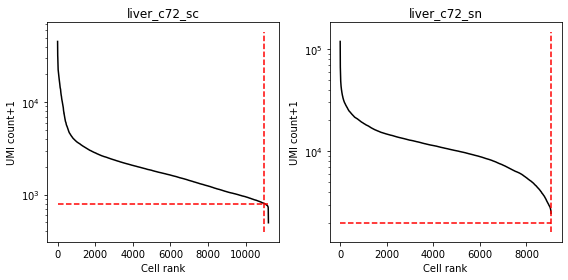

In [41]:
cf = []
thr_lb = [8e2, 2e3]
thr_ub = [1e4, 5e4]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

dataset_identifiers = ('C72_RESEQ','C72_TST')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
        ax1[k].set_title(dataset_meta[k])        
        n_annot_bcs = (meta['sample']==dataset_identifiers[k]).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_identifiers[k])]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_identifiers[k])]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

        S_arr.append(S)
        U_arr.append(U)
        for cluster in cluster_names:            
            annot_bcs = meta[(meta['sample']==dataset_identifiers[k]) \
                                       & (meta['Manual_Annotation']==cluster)]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
fig1.tight_layout()

In [40]:
[x.sum() for x in cf]

[1567, 4421, 991, 2885, 2862, 1879]

## Sc/sn comparison

In [54]:
def plot_stat(X,Y,stat,ax1,modality='spliced'):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = [x.min(),x.max()]
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))

/tmp/ipykernel_436754/1752493799.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


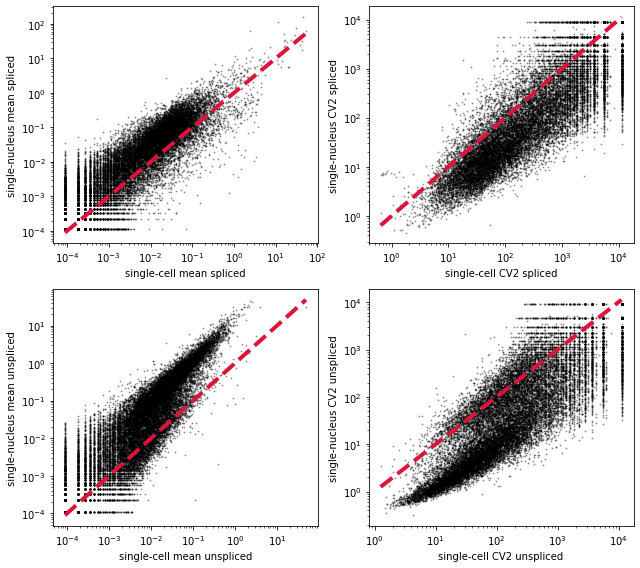

In [55]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'CV2',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()


/tmp/ipykernel_436754/680583236.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)


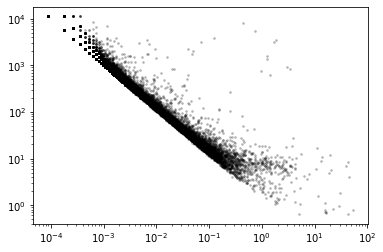

In [65]:
plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_436754/1752493799.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


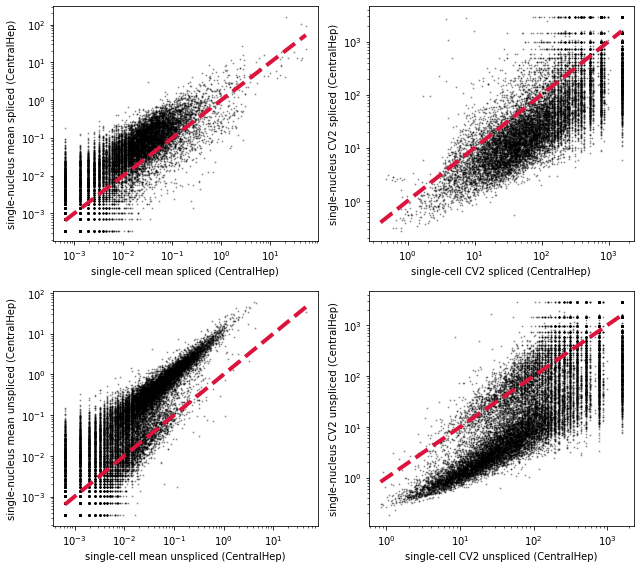

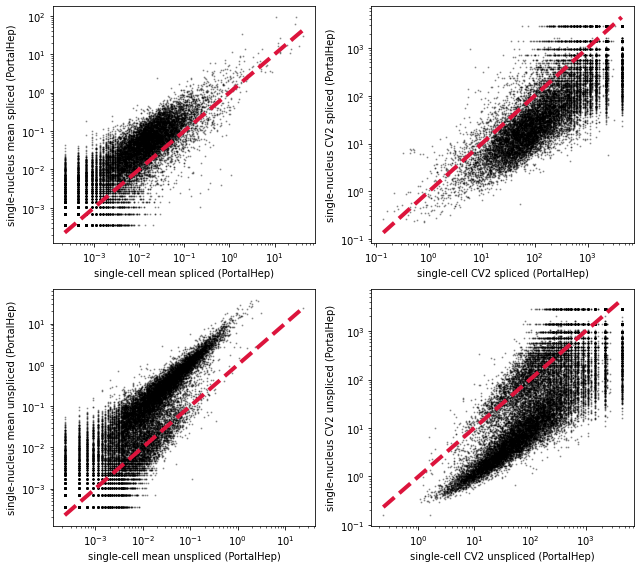

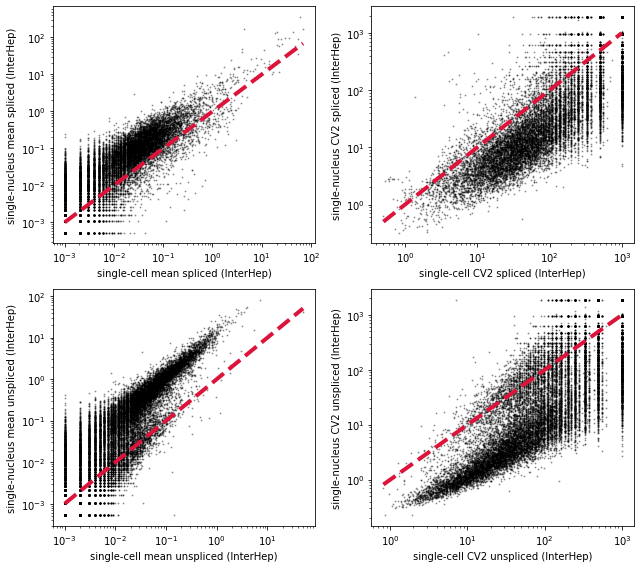

In [62]:
for k in range(3):
    fig1,ax1 = plt.subplots(2,2,figsize=(9,8))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[0][0],'spliced ({})'.format(cluster_names[k]))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[0][1],'spliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[1][0],'unspliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[1][1],'unspliced ({})'.format(cluster_names[k]))
    fig1.tight_layout()


## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [70]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [71]:
transcriptome_filepath

'../polyA_ref/gg_200525_genome_polyA_cum_3'

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1 already exists.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:1567 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:516 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep created.
INFO:root:Dataset: liver_c72_sc_PortalHep
INFO:root:4421 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:539 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep created.
INFO:root:Dataset: liver_c72_sc_InterHep
INFO:root:991 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:393 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1

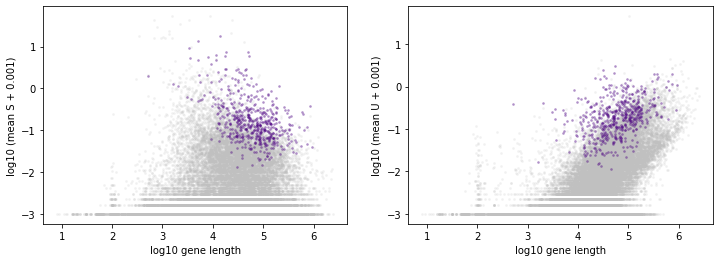

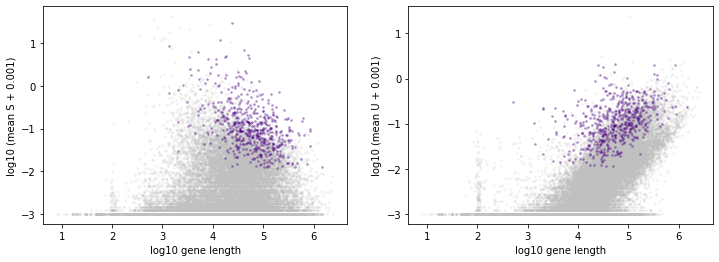

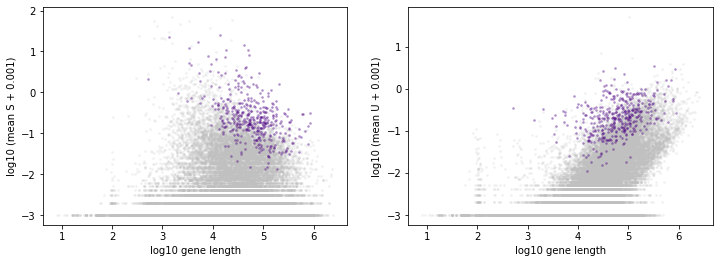

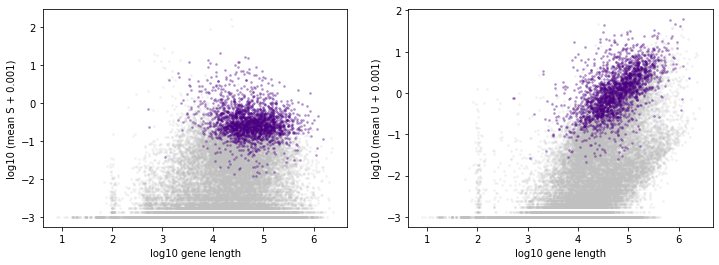

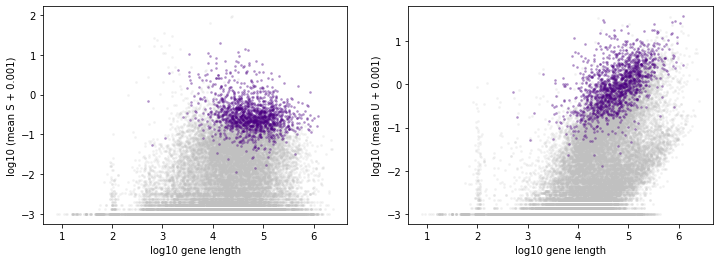

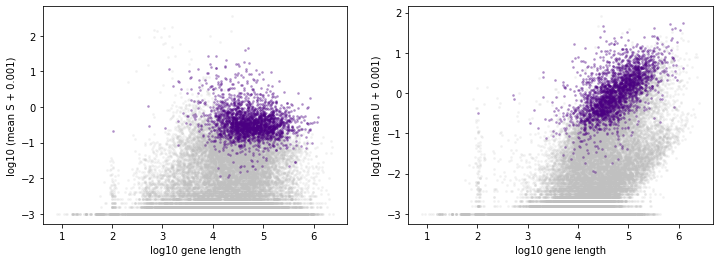

In [72]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_andrews',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

## Inference

In [ ]:
dir_string

In [ ]:
dataset_strings

Define parameter bounds, then iterate over datasets and perform the fits.

In [74]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]

gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}

In [ ]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/raw.sd.
INFO:root:Starting parallelized grid scan.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 399/420 [24:14<00:47,  2.25s/it]

## Post-processing

In [ ]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


## Analysis

In [ ]:
sr_arr_full = [[monod.analysis.load_search_results(result_strings_ext[i]),\
                monod.analysis.load_search_results(result_strings_burst[i]),\
                monod.analysis.load_search_results(result_strings_delay[i]),\
                monod.analysis.load_search_results(result_strings_delayed_splicing[i])] for i in range(n_datasets)]

In [ ]:
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

In [127]:
model_logL = [[sr.get_logL(sd) for sr in x] for x,sd in zip(sr_arr_full,sd_arr)]

In [128]:
model_logL = np.asarray(model_logL)

In [129]:
model_names=('delayed deg.','extrinsic','delayed splic.')

In [ ]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','darkgray')
bw_method=0.05

for model_index,mi in enumerate([[2,1],[0,1],[3,1]]):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,3],[1,4],[2,5]]):
        print(cluster_names[cluster_index])
        
        lim = 20
        sc_lr=model_logL[di[0],mi[0]] - model_logL[di[0],1]
        sc_lr = sc_lr[np.abs(sc_lr)<lim]
        sc_kde=scipy.stats.gaussian_kde(sc_lr,bw_method=bw_method)
        x = np.linspace(-lim,lim)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        lim = 20
        sn_lr=model_logL[di[1],mi[0]] - model_logL[di[1],1]
        sn_lr = sn_lr[np.abs(sn_lr)<lim]
        sn_kde=scipy.stats.gaussian_kde(sn_lr,bw_method=bw_method)
        x = np.linspace(-lim,lim)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])


        print((sc_lr<0).mean())
        print((sn_lr<0).mean())

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
plt.savefig('./fig/likelihood_ratio_liver.png',dpi=450)